### Imports

In [1]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns
from joblib import dump, load

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

from ipywidgets import IntProgress
from IPython.display import display

### Loading the dataset

In [35]:
data = pd.read_csv("data/sample_preprocessed_ver_2023-03-27-1679920123.csv", index_col=0)

"['new', 'govern', 'case', 'plan', 'direct', 'rifqa', 'bari', 'girl', 'fled', 'famili', 'fear', 'life', 'convert', 'christian', 'islam', 'talk', 'religion', 'muslim', 'parent', 'case', 'plan', 'also', 'work', 'toward', 'get', 'rifqa', 'return', 'home', 'accord', 'report', 'meredith', 'heagney', 'columbu', 'dispatch', 'wore', 'hijab', 'visit', 'columbu', 'mosqu', 'consist', 'file', 'slant', 'anti', 'rifqa', 'stori', 'case', 'goal', 'case', 'plan', 'reunif', 'bari', 'famili', 'ohio', 'author', 'would', 'like', 'rifqa', 'live', 'back', 'parent', 'think', 'rifqa', 'parent', 'sit', 'talk', 'respect', 'religion', 'parent', 'explain', 'islam', 'faith', 'rifqa', 'explain', 'christian', 'hope', 'might', 'lead', 'understand', 'conflict', 'led', 'impass', 'first', 'place', 'classic', 'wish', 'think', 'court', 'listen', 'expert', 'testimoni', 'islam', 'law', 'discuss', 'apost', 'islam', 'law', 'apost', 'order', 'return', 'islam', 'kill', 'refus', 'mediat', 'islam', 'christian', 'tell', 'mecca', 'm

In [3]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)

In [4]:
data['content'] = data['content'].apply(string_to_list)

In [5]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [6]:
labelperc(data)

{'fake': 52.18250700049415, 'reliable': 47.817492999505845}

In [7]:
len(data)

6071

### Simple Model - Logistic Regression

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=200000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x28b0a1e10>,
                max_features=200000)

In [11]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aadi', ..., 'zynga', 'zypern', 'zyuganov'],
      dtype=object)

In [12]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [13]:
logreg = LogisticRegression(solver='sag')
logreg.fit(X_train, y_train)

/Users/mikkelkjaerulf/miniconda3/envs/fake_news/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='sag')

In [14]:
dump(logreg, "models/logreg_vocab_200000_solver_sag.joblib")

['models/logreg_vocab_200000_solver_sag.joblib']

In [15]:
pred = logreg.predict(X_val)

In [16]:
accuracy_score(y_val, pred)

0.7627677100494233

In [17]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7428571428571429

[[255  63]
 [ 81 208]]


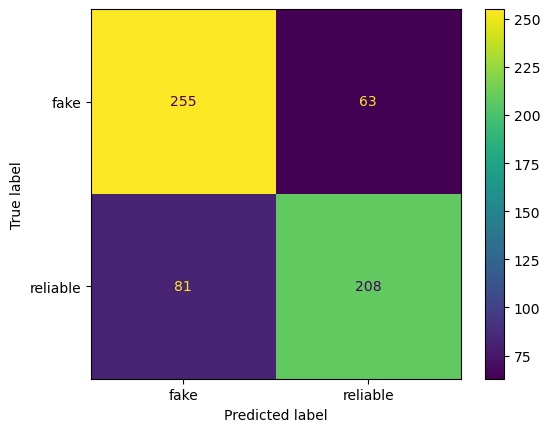

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()



### Advanced Model - Naive Bayes

In [19]:
#def to_bigrams(words):
#    return list(nltk.bigrams(words))

In [20]:
#chunk_size = 10000
#data_chunks = [data.iloc[i:i+chunk_size] for i in range(0, data.shape[0], chunk_size)]

In [21]:
#for chunk in data_chunks:
#    chunk['content'] = chunk['content'].apply(to_bigrams)

In [22]:
#data['content'] = data['content'].apply(to_bigrams)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x : x, max_features=10000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer=<function <lambda> at 0x29197fc70>, max_features=10000)

In [25]:
X_train.shape

(4856,)

In [26]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [27]:
vectorizer.get_feature_names_out()

array(['aaron', 'aaryn', 'abandon', ..., 'zone', 'zoo', 'zuna'],
      dtype=object)

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [29]:
dump(nb, "models/nb_vocab_10000_bigrams_better_df_load.joblib")

['models/nb_vocab_10000_bigrams_better_df_load.joblib']

In [30]:
pred = nb.predict(X_val)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.7627677100494233

In [32]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7410071942446045

[[257  61]
 [ 83 206]]


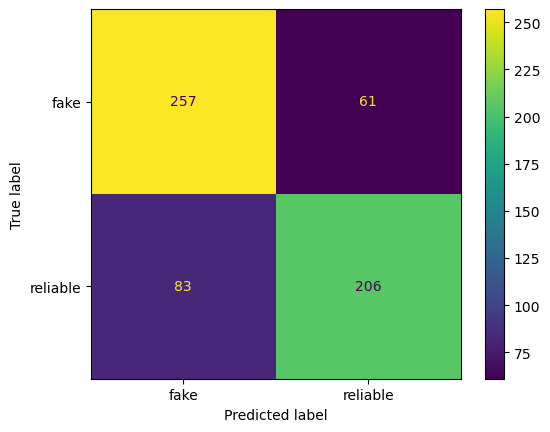

In [33]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()